In [2]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'promise19_dataset.csv'
df = pd.read_csv(file_path)

# Display the first few rows to verify
print("Dataset loaded successfully. Here are the first 5 rows:")
print(df.head())

Dataset loaded successfully. Here are the first 5 rows:
  Project Owner                  Manager          Category         Key  \
0  Buildr   ASF  Apache Buildr Committee  build-management  BUILDR-235   
1  Buildr   ASF  Apache Buildr Committee  build-management  BUILDR-236   
2  Buildr   ASF  Apache Buildr Committee  build-management  BUILDR-239   
3  Buildr   ASF  Apache Buildr Committee  build-management  BUILDR-241   
4  Buildr   ASF  Apache Buildr Committee  build-management  BUILDR-243   

  Priority  Status        Reporter Assignee                Components  ...  \
0  Trivial  Closed     alexismidon      NaN  JRuby Site/documentation  ...   
1    Major  Closed     alexismidon      NaN                       NaN  ...   
2    Major  Closed           jmuzz      NaN             Core features  ...   
3    Major  Closed        rsutphin      NaN                       IDE  ...   
4    Minor  Closed  digitalsanctum      NaN                 Compilers  ...   

  SrcAddLines SrcDelLines Test

## EDA

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73293 entries, 0 to 73292
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Project                    73293 non-null  object 
 1   Owner                      73293 non-null  object 
 2   Manager                    73293 non-null  object 
 3   Category                   73293 non-null  object 
 4   Key                        73293 non-null  object 
 5   Priority                   73292 non-null  object 
 6   Status                     73293 non-null  object 
 7   Reporter                   73271 non-null  object 
 8   Assignee                   65176 non-null  object 
 9   Components                 46592 non-null  object 
 10  SummaryTopWords            72633 non-null  object 
 11  DescriptionTopWords        68968 non-null  object 
 12  CommentsTopWords           70286 non-null  object 
 13  CreationDate           

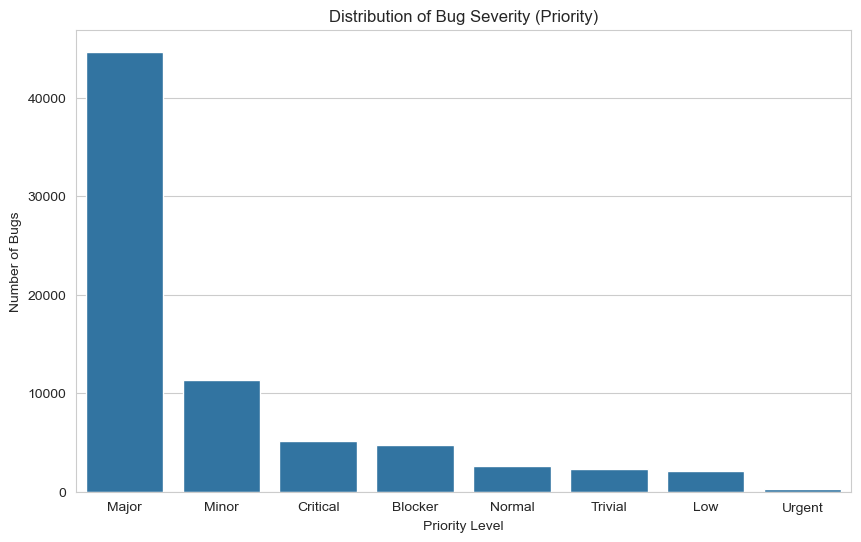

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for plots
sns.set_style('whitegrid')

# 1. Get a summary of the dataframe
print("--- DataFrame Info ---")
df.info()

# 2. Get descriptive statistics for numerical columns
print("\n--- Descriptive Statistics ---")
print(df.describe())

# 3. Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# 4. Visualize the distribution of the target variable 'Priority'
plt.figure(figsize=(10, 6))
sns.countplot(x='Priority', data=df, order = df['Priority'].value_counts().index)
plt.title('Distribution of Bug Severity (Priority)')
plt.xlabel('Priority Level')
plt.ylabel('Number of Bugs')
plt.show()

## PREPROCESSING

In [4]:
# --- 1. Handle Missing Target Value ---
# Drop the one row where 'Priority' is NaN
df.dropna(subset=['Priority'], inplace=True)


# --- 2. Feature Engineering ---
# Convert date columns to datetime objects
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df['ResolutionDate'] = pd.to_datetime(df['ResolutionDate'])

# Create 'BugLifetime_days' feature
df['BugLifetime_days'] = (df['ResolutionDate'] - df['CreationDate']).dt.days

# Combine text features into a single column for NLP
text_features = ['SummaryTopWords', 'DescriptionTopWords', 'CommentsTopWords']
# Fill NaN values in text columns with an empty string before combining
for col in text_features:
    df[col] = df[col].fillna('')

df['CombinedText'] = df[text_features].apply(lambda row: ' '.join(row), axis=1)


# --- 3. Feature Selection ---
# Define the features we want to keep. This is a mix of numerical, categorical, and our new engineered features.
selected_features = [
    'Project', 'Reporter', 'Assignee', 'Components', # Categorical Features
    'NoComments', 'NoWatchers', 'NoAttachments', 'NoCommits', 'LoC', # Numerical Features
    'BugLifetime_days', # Engineered Numerical Feature
    'CombinedText', # Engineered Text Feature
    'Priority' # Target Variable
]

# Create a new dataframe with only the selected features
df_model = df[selected_features].copy()


# --- 4. Handle Remaining Missing Data in Selected Features ---
# For categorical features, we'll fill NaN with the string 'Unknown'
for col in ['Reporter', 'Assignee', 'Components']:
    df_model[col] = df_model[col].fillna('Unknown')


# --- 5. Encode the Target Variable ---
# We will use scikit-learn's LabelEncoder for this
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_model['Priority_encoded'] = le.fit_transform(df_model['Priority'])

# Store the mapping from encoded number to original label for later interpretation
priority_mapping = {index: label for index, label in enumerate(le.classes_)}

print("--- Preprocessing and Feature Engineering Complete ---")
print("New DataFrame shape:", df_model.shape)
print("\nMissing values in the new DataFrame:")
print(df_model.isnull().sum())
print("\nExample of the new DataFrame:")
print(df_model.head())
print("\nPriority to Encoded Label Mapping:")
print(priority_mapping)

--- Preprocessing and Feature Engineering Complete ---
New DataFrame shape: (73292, 13)

Missing values in the new DataFrame:
Project             0
Reporter            0
Assignee            0
Components          0
NoComments          0
NoWatchers          0
NoAttachments       0
NoCommits           0
LoC                 0
BugLifetime_days    0
CombinedText        0
Priority            0
Priority_encoded    0
dtype: int64

Example of the new DataFrame:
  Project        Reporter Assignee                Components  NoComments  \
0  Buildr     alexismidon  Unknown  JRuby Site/documentation           0   
1  Buildr     alexismidon  Unknown                   Unknown           3   
2  Buildr           jmuzz  Unknown             Core features           2   
3  Buildr        rsutphin  Unknown                       IDE           1   
4  Buildr  digitalsanctum  Unknown                 Compilers           1   

   NoWatchers  NoAttachments  NoCommits     LoC  BugLifetime_days  \
0           0     

## Baseline ML

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# --- 1. Define Features (X) and Target (y) ---
# We drop 'Priority' because 'Priority_encoded' is our numerical target
X = df_model.drop(['Priority', 'Priority_encoded'], axis=1)
y = df_model['Priority_encoded']

# --- Define which columns are which type ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=object).columns.tolist()
# We remove our text feature from the categorical list
categorical_features.remove('CombinedText')
text_feature = 'CombinedText'


# --- 2. Create the Preprocessing Pipeline (ColumnTransformer) ---
# This applies the correct transformation to each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), text_feature)
    ],
    remainder='drop' # Drop any columns we didn't specify
)


# --- 3. Split the data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 4. Create and Train the Final Model Pipeline ---
# Chain the preprocessor and the classifier together
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

# Train the model!
print("--- Training the baseline model... ---")
model_pipeline.fit(X_train, y_train)
print("--- Model training complete! ---")

--- Training the baseline model... ---
--- Model training complete! ---


--- Evaluating the baseline model... ---

--- Classification Report ---
              precision    recall  f1-score   support

     Blocker       0.49      0.22      0.31       954
    Critical       0.41      0.14      0.20      1032
         Low       0.66      0.59      0.62       415
       Major       0.72      0.91      0.80      8928
       Minor       0.47      0.30      0.36      2275
      Normal       0.65      0.77      0.70       528
     Trivial       0.49      0.15      0.23       469
      Urgent       0.40      0.03      0.06        58

    accuracy                           0.67     14659
   macro avg       0.53      0.39      0.41     14659
weighted avg       0.63      0.67      0.63     14659


--- Generating Confusion Matrix... ---


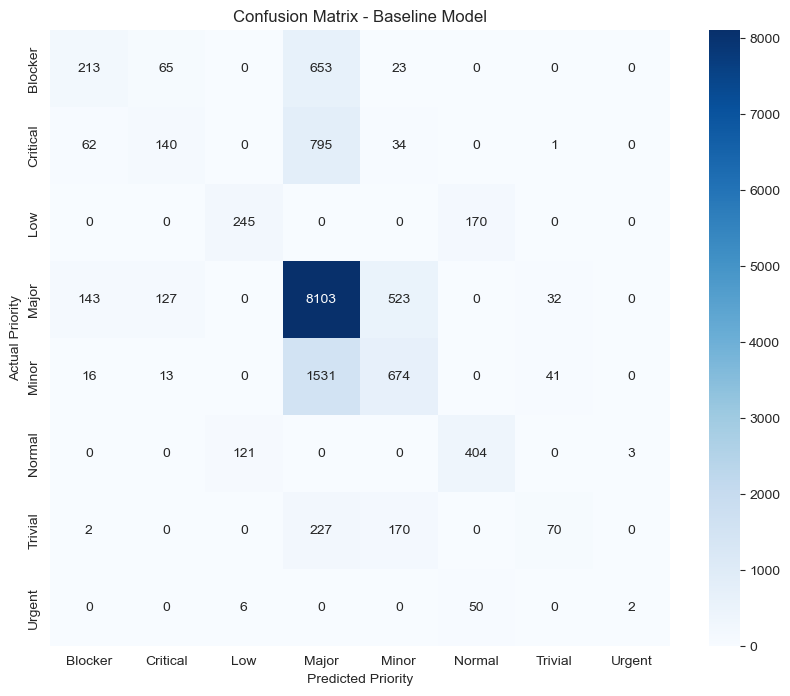

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Make predictions on the test set ---
print("--- Evaluating the baseline model... ---")
y_pred = model_pipeline.predict(X_test)

# --- 2. Print the Classification Report ---
# We use the original labels for better readability
original_labels = le.inverse_transform(model_pipeline.classes_)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=original_labels))

# --- 3. Visualize the Confusion Matrix ---
print("\n--- Generating Confusion Matrix... ---")
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix - Baseline Model')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Renaming to avoid confusion
from sklearn.linear_model import LogisticRegression

# Note: The preprocessor is the same one we defined in Step 4.
# We don't need to redefine it if you are running this in the same notebook.

# --- Create the new SMOTE-enhanced pipeline ---
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# --- Train the new model ---
print("--- Training the SMOTE-enhanced model... ---")
smote_pipeline.fit(X_train, y_train)
print("--- Model training complete! ---")

--- Training the SMOTE-enhanced model... ---
--- Model training complete! ---


--- Evaluating the SMOTE-enhanced model... ---

--- Classification Report (SMOTE Model) ---
              precision    recall  f1-score   support

     Blocker       0.29      0.48      0.36       954
    Critical       0.22      0.38      0.28      1032
         Low       0.62      0.61      0.61       415
       Major       0.80      0.59      0.68      8928
       Minor       0.38      0.49      0.43      2275
      Normal       0.64      0.67      0.66       528
     Trivial       0.27      0.42      0.33       469
      Urgent       0.26      0.19      0.22        58

    accuracy                           0.55     14659
   macro avg       0.43      0.48      0.45     14659
weighted avg       0.63      0.55      0.58     14659


--- Generating Confusion Matrix (SMOTE Model)... ---


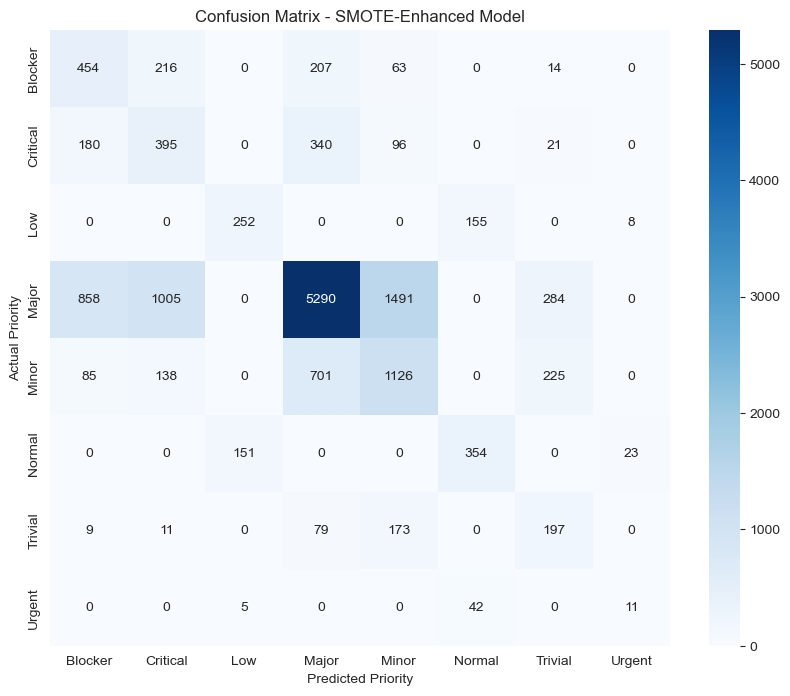

In [9]:
# --- 1. Make predictions with the new SMOTE pipeline ---
print("--- Evaluating the SMOTE-enhanced model... ---")
y_pred_smote = smote_pipeline.predict(X_test)

# --- 2. Print the new Classification Report ---
print("\n--- Classification Report (SMOTE Model) ---")
print(classification_report(y_test, y_pred_smote, target_names=original_labels))

# --- 3. Visualize the new Confusion Matrix ---
print("\n--- Generating Confusion Matrix (SMOTE Model)... ---")
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix - SMOTE-Enhanced Model')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

## RF MODEL

--- Training the Best Model (RandomForest + SMOTE)... ---
--- Model training complete! ---

--- Evaluating the Best Model... ---

--- Classification Report (Best Model) ---
              precision    recall  f1-score   support

     Blocker       0.31      0.16      0.21       954
    Critical       0.27      0.15      0.19      1032
         Low       0.59      0.66      0.62       415
       Major       0.68      0.90      0.78      8928
       Minor       0.38      0.12      0.19      2275
      Normal       0.65      0.66      0.66       528
     Trivial       0.36      0.07      0.12       469
      Urgent       0.00      0.00      0.00        58

    accuracy                           0.63     14659
   macro avg       0.41      0.34      0.35     14659
weighted avg       0.56      0.63      0.57     14659


--- Generating Confusion Matrix (Best Model)... ---


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


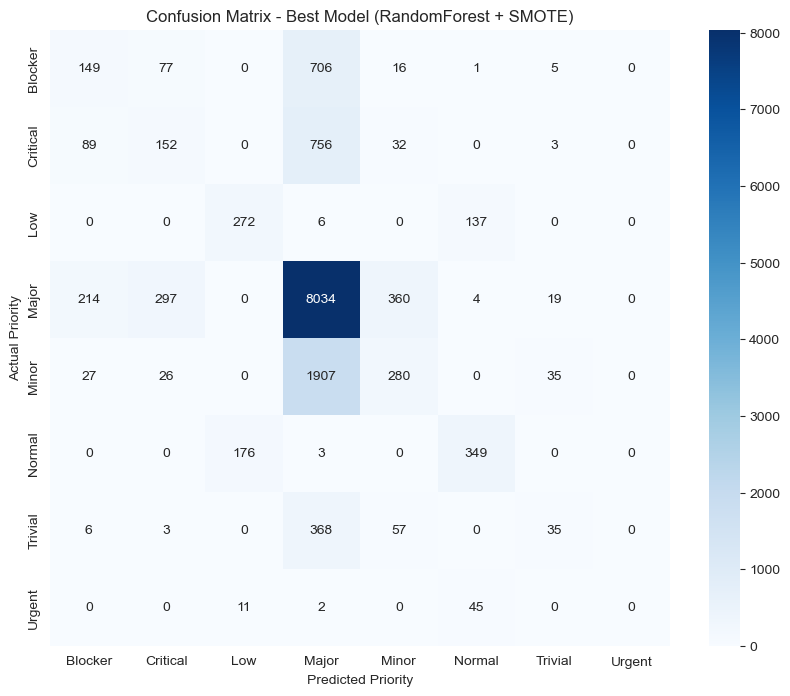

In [10]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Create the new Best Model Pipeline ---
# This pipeline combines our previous preprocessor, SMOTE, and the new RandomForestClassifier
best_model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# n_estimators=100 means we'll use 100 decision trees.
# n_jobs=-1 will use all available CPU cores to speed up training.

# --- 2. Train the Best Model ---
print("--- Training the Best Model (RandomForest + SMOTE)... ---")
best_model_pipeline.fit(X_train, y_train)
print("--- Model training complete! ---")


# --- 3. Evaluate the Best Model ---
print("\n--- Evaluating the Best Model... ---")
y_pred_best = best_model_pipeline.predict(X_test)

# Print the Classification Report
print("\n--- Classification Report (Best Model) ---")
print(classification_report(y_test, y_pred_best, target_names=original_labels))

# Visualize the Confusion Matrix
print("\n--- Generating Confusion Matrix (Best Model)... ---")
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix - Best Model (RandomForest + SMOTE)')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

## DEEP LEARNING

--- Class Weights calculated to handle imbalance ---
{0: 1.9201270631385905, 1: 1.775896535013327, 2: 4.412477423239013, 3: 0.20524012881545786, 4: 0.8053098560597737, 5: 3.475165955429113, 6: 3.902622470713525, 7: 31.865760869565218}


C:\Users\Coral\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structured_input    │ (None, 17577)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 150, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  2,249,984 │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    131,584 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │      1,032 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,695,496 (14.10 MB)

 Trainable params: 3,695,496 (14.10 MB)

 Non-trainable params: 0 (0.00 B)


--- Training the Deep Learning Model with Early Stopping... ---
Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 70s 163ms/step - accuracy: 0.2406 - loss: 1.6179 - val_accuracy: 0.4495 - val_loss: 1.2759
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - accuracy: 0.4643 - loss: 1.0966 - val_accuracy: 0.4267 - val_loss: 1.2995
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - accuracy: 0.5483 - loss: 0.9208 - val_accuracy: 0.4591 - val_loss: 1.2533
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - accuracy: 0.6059 - loss: 0.7462 - val_accuracy: 0.4311 - val_loss: 1.3326
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - accuracy: 0.6411 - loss: 0.6280 - val_accuracy: 0.4494 - val_loss: 1.3246
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - accuracy: 0.6760 - loss: 0.5306 - val_accuracy: 0.4882 - val_loss: 1.3102
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 56s 134ms/step - accuracy: 0.6942 - loss: 0.4810 - val_accuracy: 0.4504 - val_loss: 1.4391
Epoch 8/20
413/413

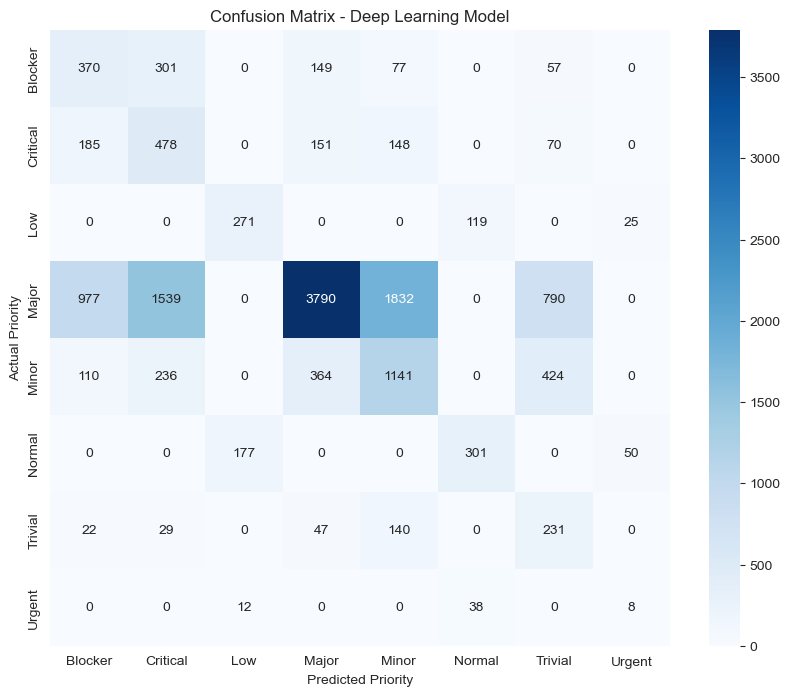

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Import the EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data Preparation ---
# (This section is identical to the previous step)
numerical_features = ['NoComments', 'NoWatchers', 'NoAttachments', 'NoCommits', 'LoC', 'BugLifetime_days']
categorical_features = ['Project', 'Reporter', 'Assignee', 'Components']
text_feature = 'CombinedText'
target = 'Priority_encoded'

X = df_model[numerical_features + categorical_features + [text_feature]]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

VOCAB_SIZE = 10000
MAX_LEN = 150
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train[text_feature])

X_train_text = tokenizer.texts_to_sequences(X_train[text_feature])
X_train_text = pad_sequences(X_train_text, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_text = tokenizer.texts_to_sequences(X_test[text_feature])
X_test_text = pad_sequences(X_test_text, maxlen=MAX_LEN, padding='post', truncating='post')

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_cat = encoder.transform(X_test[categorical_features]).toarray()

X_train_structured = np.hstack([X_train_num, X_train_cat])
X_test_structured = np.hstack([X_test_num, X_test_cat])


# --- 2. Handle Class Imbalance ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("--- Class Weights calculated to handle imbalance ---")
print(class_weights_dict)

# --- 3. Build the Hybrid Model ---
# (This section is identical to the previous step)
text_input = Input(shape=(MAX_LEN,), name='text_input')
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN)(text_input)
lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

structured_input = Input(shape=(X_train_structured.shape[1],), name='structured_input')
dense_layer = Dense(128, activation='relu')(structured_input)
dense_layer = Dropout(0.3)(dense_layer)

merged = concatenate([lstm_layer, dense_layer])
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.3)(merged)

num_classes = len(np.unique(y_train))
output = Dense(num_classes, activation='softmax')(merged)

model = Model(inputs=[text_input, structured_input], outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


# --- 4. Train the Model with Early Stopping ---
print("\n--- Training the Deep Learning Model with Early Stopping... ---")

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model, adding the callback
history = model.fit(
    [X_train_text, X_train_structured], y_train,
    epochs=20,  # We can set a higher number of epochs; early stopping will handle the rest
    batch_size=128,
    validation_split=0.1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping], # Add the callback here
    verbose=1
)
print("--- Model training complete! ---")

# --- 5. Evaluate the Model ---
# (This section is identical to the previous step)
print("\n--- Evaluating the Deep Learning Model... ---")
y_pred_probs = model.predict([X_test_text, X_test_structured])
y_pred = np.argmax(y_pred_probs, axis=1)

original_labels = le.inverse_transform(np.arange(num_classes))
print("\n--- Classification Report (Deep Learning Model) ---")
print(classification_report(y_test, y_pred, target_names=original_labels))

print("\n--- Generating Confusion Matrix (Deep Learning Model)... ---")
conf_matrix_dl = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix - Deep Learning Model')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

## BAYESIAN

Trial 10 Complete [00h 27m 36s]
val_accuracy: 0.47991815209388733

Best val_accuracy So Far: 0.48460817337036133
Total elapsed time: 02h 37m 37s
--- Search Complete ---

--- Evaluating the Best Model Found by Bayesian Optimization ---

The hyperparameter search is complete. The optimal number of units in the LSTM layer is 256 
and the optimal learning rate for the optimizer is 0.01.

Epoch 1/20
1833/1833 ━━━━━━━━━━━━━━━━━━━━ 258s 140ms/step - accuracy: 0.2541 - loss: 1.6097 - val_accuracy: 0.4280 - val_loss: 1.3145
Epoch 2/20
1833/1833 ━━━━━━━━━━━━━━━━━━━━ 252s 137ms/step - accuracy: 0.3334 - loss: 1.3545 - val_accuracy: 0.3295 - val_loss: 1.4922
Epoch 3/20
1833/1833 ━━━━━━━━━━━━━━━━━━━━ 252s 138ms/step - accuracy: 0.3706 - loss: 1.3401 - val_accuracy: 0.2929 - val_loss: 1.4871
Epoch 4/20
1833/1833 ━━━━━━━━━━━━━━━━━━━━ 253s 138ms/step - accuracy: 0.3737 - loss: 1.2573 - val_accuracy: 0.3641 - val_loss: 1.3865
Epoch 4: early stopping

--- Final Evaluation on Test Set ---
459/459 ━━━━━━━

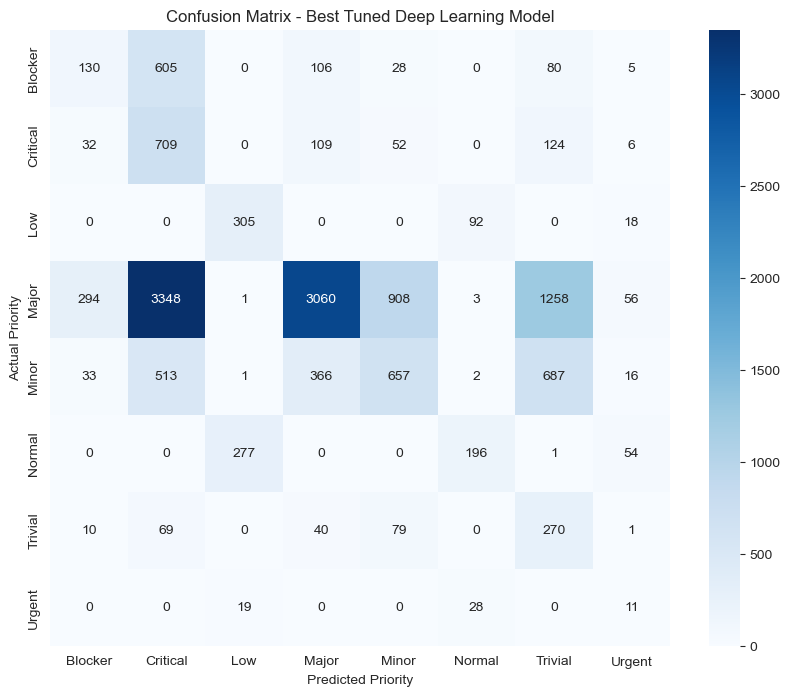

In [16]:
# First, ensure KerasTuner is installed
# !pip install -q -U keras-tuner

import keras_tuner as kt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data Preparation (Identical to previous steps) ---
numerical_features = ['NoComments', 'NoWatchers', 'NoAttachments', 'NoCommits', 'LoC', 'BugLifetime_days']
categorical_features = ['Project', 'Reporter', 'Assignee', 'Components']
text_feature = 'CombinedText'
target = 'Priority_encoded'

X = df_model[numerical_features + categorical_features + [text_feature]]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess Text
VOCAB_SIZE = 10000
MAX_LEN = 150
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train[text_feature])
X_train_text = pad_sequences(tokenizer.texts_to_sequences(X_train[text_feature]), maxlen=MAX_LEN, padding='post', truncating='post')
X_test_text = pad_sequences(tokenizer.texts_to_sequences(X_test[text_feature]), maxlen=MAX_LEN, padding='post', truncating='post')

# Preprocess Structured Data
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])
X_train_cat = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_cat = encoder.transform(X_test[categorical_features]).toarray()
X_train_structured = np.hstack([X_train_num, X_train_cat])
X_test_structured = np.hstack([X_test_num, X_test_cat])

# Get class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


# --- 2. Define the Model-Building Function for the Tuner ---
def build_model(hp):
    # Text Input Branch
    text_input = Input(shape=(MAX_LEN,), name='text_input')
    hp_embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=hp_embedding_dim)(text_input)
    hp_lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    lstm_layer = LSTM(hp_lstm_units)(embedding_layer)

    # Structured Data Input Branch
    structured_input = Input(shape=(X_train_structured.shape[1],), name='structured_input')
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    dense_layer = Dense(hp_dense_units, activation='relu')(structured_input)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    dense_layer = Dropout(hp_dropout_1)(dense_layer)

    # Concatenate Branches
    merged = concatenate([lstm_layer, dense_layer])
    hp_merged_dense_units = hp.Int('merged_dense_units', min_value=64, max_value=256, step=64)
    merged = Dense(hp_merged_dense_units, activation='relu')(merged)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    merged = Dropout(hp_dropout_2)(merged)

    # Output Layer
    output = Dense(len(class_weights_dict), activation='softmax')(merged)

    model = Model(inputs=[text_input, structured_input], outputs=output)
    
    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# --- 3. Instantiate the Tuner ---
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different models to test
    directory='my_dir',
    project_name='bug_severity_tuning'
)

# Define EarlyStopping callback to use during the search
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# --- 4. Run the Search ---
print("--- Starting Bayesian Optimization Search ---")
tuner.search(
    [X_train_text, X_train_structured], y_train,
    epochs=15,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)
print("--- Search Complete ---")

# --- 5. Retrieve and Evaluate the Best Model ---
print("\n--- Evaluating the Best Model Found by Bayesian Optimization ---")
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('lstm_units')} 
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train it on the full training data
history = best_model.fit(
    [X_train_text, X_train_structured], y_train,
    epochs=20, # Train for more epochs on the full data
    validation_data=([X_test_text, X_test_structured], y_test),
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)]
)

# Final evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_probs = best_model.predict([X_test_text, X_test_structured])
y_pred = np.argmax(y_pred_probs, axis=1)

num_classes = len(class_weights_dict)
original_labels = le.inverse_transform(np.arange(num_classes))
print("\n--- Classification Report (Best Tuned Model) ---")
print(classification_report(y_test, y_pred, target_names=original_labels))

print("\n--- Generating Confusion Matrix (Best Tuned Model)... ---")
conf_matrix_best_tuned = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix - Best Tuned Deep Learning Model')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

## BEST

--- Class Weights calculated to handle imbalance ---
{0: 1.9201270631385905, 1: 1.775896535013327, 2: 4.412477423239013, 3: 0.20524012881545786, 4: 0.8053098560597737, 5: 3.475165955429113, 6: 3.902622470713525, 7: 31.865760869565218}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ structured_input    │ (None, 17577)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │  2,249,984 │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 150, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 128)       │     99,072 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ gru[0][0],        │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │      1,032 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,664,008 (13.98 MB)

 Trainable params: 3,663,496 (13.98 MB)

 Non-trainable params: 512 (2.00 KB)


--- Training the Enhanced Deep Learning Model... ---
Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 210s 502ms/step - accuracy: 0.2105 - loss: 1.9958 - val_accuracy: 0.2831 - val_loss: 1.5623
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 205s 497ms/step - accuracy: 0.3643 - loss: 1.2540 - val_accuracy: 0.3651 - val_loss: 1.4214
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 203s 491ms/step - accuracy: 0.4437 - loss: 1.0521 - val_accuracy: 0.4004 - val_loss: 1.3446
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 205s 497ms/step - accuracy: 0.5021 - loss: 0.9033 - val_accuracy: 0.4391 - val_loss: 1.2966
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 205s 497ms/step - accuracy: 0.5642 - loss: 0.7553 - val_accuracy: 0.4349 - val_loss: 1.3274
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 205s 496ms/step - accuracy: 0.6035 - loss: 0.6454 - val_accuracy: 0.4505 - val_loss: 1.3295
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 204s 494ms/step - accuracy: 0.6284 - loss: 0.6027 - val_accuracy: 0.4725 - val_loss: 1.3043
Epoch 7: early stoppin

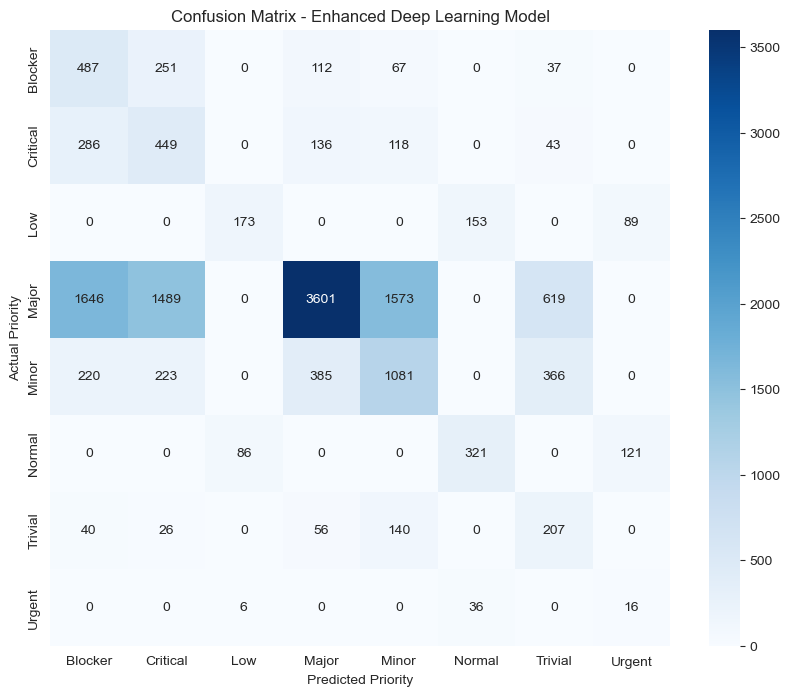

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
# Import GRU and BatchNormalization
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, concatenate, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data Preparation (Identical to previous steps) ---
numerical_features = ['NoComments', 'NoWatchers', 'NoAttachments', 'NoCommits', 'LoC', 'BugLifetime_days']
categorical_features = ['Project', 'Reporter', 'Assignee', 'Components']
text_feature = 'CombinedText'
target = 'Priority_encoded'

X = df_model[numerical_features + categorical_features + [text_feature]]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess Text
VOCAB_SIZE = 10000
MAX_LEN = 150
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train[text_feature])
X_train_text = pad_sequences(tokenizer.texts_to_sequences(X_train[text_feature]), maxlen=MAX_LEN, padding='post', truncating='post')
X_test_text = pad_sequences(tokenizer.texts_to_sequences(X_test[text_feature]), maxlen=MAX_LEN, padding='post', truncating='post')

# Preprocess Structured Data
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])
X_train_cat = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_cat = encoder.transform(X_test[categorical_features]).toarray()
X_train_structured = np.hstack([X_train_num, X_train_cat])
X_test_structured = np.hstack([X_test_num, X_test_cat])


# --- 2. Handle Class Imbalance with Class Weights ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("--- Class Weights calculated to handle imbalance ---")
print(class_weights_dict)

# --- 3. Build the Enhanced Hybrid Model ---
# Text Input Branch (GRU)
text_input = Input(shape=(MAX_LEN,), name='text_input')
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=128)(text_input)
gru_layer = GRU(128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

# Structured Data Input Branch (MLP with Batch Normalization)
structured_input = Input(shape=(X_train_structured.shape[1],), name='structured_input')
dense_layer = Dense(128, activation='relu')(structured_input)
dense_layer = BatchNormalization()(dense_layer)
dense_layer = Dropout(0.4)(dense_layer)

# Concatenate Branches
merged = concatenate([gru_layer, dense_layer])
merged = Dense(128, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.4)(merged)

# Output Layer
num_classes = len(np.unique(y_train))
output = Dense(num_classes, activation='softmax')(merged)

# Create the model
enhanced_model = Model(inputs=[text_input, structured_input], outputs=output)

# Compile using standard loss, as we will pass class_weight to .fit()
enhanced_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
enhanced_model.summary()


# --- 4. Train the Model with Early Stopping & Class Weights ---
print("\n--- Training the Enhanced Deep Learning Model... ---")

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = enhanced_model.fit(
    [X_train_text, X_train_structured], y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    class_weight=class_weights_dict, # Pass class weights here
    callbacks=[early_stopping],
    verbose=1
)
print("--- Model training complete! ---")


# --- 5. Evaluate the Enhanced Model ---
print("\n--- Evaluating the Enhanced Deep Learning Model... ---")
y_pred_probs = enhanced_model.predict([X_test_text, X_test_structured])
y_pred = np.argmax(y_pred_probs, axis=1)

original_labels = le.inverse_transform(np.arange(num_classes))
print("\n--- Classification Report (Enhanced Model) ---")
print(classification_report(y_test, y_pred, target_names=original_labels))

print("\n--- Generating Confusion Matrix (Enhanced Model)... ---")
conf_matrix_enhanced = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_enhanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix - Enhanced Deep Learning Model')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# Import TruncatedSVD for dimensionality reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data Preparation (Identical) ---
numerical_features = ['NoComments', 'NoWatchers', 'NoAttachments', 'NoCommits', 'LoC', 'BugLifetime_days']
categorical_features = ['Project', 'Reporter', 'Assignee', 'Components']
text_feature = 'CombinedText'
target = 'Priority_encoded'

X = df_model.drop(['Priority', 'Priority_encoded'], axis=1)
y = df_model['Priority_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 2. Define the Preprocessing Pipeline with Dimensionality Reduction ---
# Create a new pipeline specifically for text features that includes SVD
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('svd', TruncatedSVD(n_components=100, random_state=42)) # Reduce 5000 features to 100
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        # Use the new text_pipeline here
        ('text', text_pipeline, text_feature)
    ],
    remainder='drop'
)

print("--- Applying preprocessing with dimensionality reduction... ---")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# --- 3. Apply SMOTEENN ---
print("--- Applying SMOTEENN to the reduced training data... ---")
smote_enn = SMOTEENN(random_state=42, n_jobs=-1)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_processed, y_train)


# --- 4. Define Base Models ---
estimators = [
    ('logistic_regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('lightgbm', LGBMClassifier(random_state=42))
]


# --- 5. Create and Train the Stacking Ensemble ---
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3,
    n_jobs=1
)

print("--- Training the Final Stacking Ensemble Model... ---")
stacking_model.fit(X_train_resampled, y_train_resampled)
print("--- Model training complete! ---")


# --- 6. Evaluate the Stacking Ensemble ---
print("\n--- Evaluating the Final Stacking Ensemble Model... ---")
y_pred_stack = stacking_model.predict(X_test_processed)

original_labels = le.inverse_transform(stacking_model.classes_)
print("\n--- Classification Report (Stacking Ensemble) ---")
print(classification_report(y_test, y_pred_stack, target_names=original_labels))

print("\n--- Generating Confusion Matrix (Stacking Ensemble)... ---")
conf_matrix_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_stack, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix - Stacking Ensemble Model')
plt.ylabel('Actual Priority')
plt.xlabel('Predicted Priority')
plt.show()

--- Applying preprocessing with dimensionality reduction... ---
--- Applying SMOTEENN to the reduced training data... ---


C:\ProgramData\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^